# Classification: Data Modeling

In [1]:
import pickle

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from os.path import exists

from scipy.stats import uniform
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

pd.set_option('display.max_colwidth', 100)

In [2]:
target = 'tweets'

# The first line for upsampled data, the second for the original data
supervised_up_target_path = f'../dataset/processed/supervised_{target}_upsampled.csv'
supervised_down_target_path = f'../dataset/processed/supervised_{target}_downsampled.csv'
supervised_target_path = f'../dataset/processed/supervised_{target}.csv'

model_path = '../dataset/model/sental_model.pkl'
model_best_params_path = '../dataset/model/svm_best_params.pkl'
vectorizer_path = '../dataset/model/sental_vectorizer.pkl'

In [3]:
# df = pd.read_csv(supervised_target_path, delimiter=';')
df = pd.read_csv(supervised_up_target_path, delimiter=';')
# df = pd.read_csv(supervised_down_target_path, delimiter=';')

df

,index,date,content,case_folding,text_clean,tokens,tokens_ready,review,polarity,sentiment,label
0,0,2022-09-04 23:59:55+00:00,@soeyoto1 @msaid_didu Bukti kalau Pemerintahan Pak @jokowi tidak pro rakyat. Tapi pro oligarki. ...,@soeyoto1 @msaid_didu bukti kalau pemerintahan pak @jokowi tidak pro rakyat. tapi pro oligarki. ...,bukti kalau pemerintahan pak tidak pro rakyat tapi pro oligarki vivo bbmnya lebih murah dari pem...,"['bukti', 'pemerintahan', 'pro', 'rakyat', 'pro', 'oligarki', 'bbmnya', 'murah', 'pemerintah', '...","['bukti', 'perintah', 'pro', 'rakyat', 'pro', 'oligarki', 'bbmnya', 'murah', 'perintah', 'harga'...",bukti perintah pro rakyat pro oligarki bbmnya murah perintah harga bodoh,-7,0,Negative
1,1,2022-09-04 23:59:38+00:00,"@KompasTV Mentri esdm, trus patokanmu apa? Kantong pertamina udah jebol karna banyak dikorupsi, ...","@kompastv mentri esdm, trus patokanmu apa? kantong pertamina udah jebol karna banyak dikorupsi, ...",mentri esdm trus patokanmu apa kantong pertamina udah jebol karna banyak dikorupsi imbasnya raky...,"['menteri', 'esdm', 'patokanmu', 'kantong', 'jebol', 'dikorupsi', 'imbasnya', 'rakyat', 'menangg...","['menteri', 'esdm', 'patok', 'kantong', 'jebol', 'korupsi', 'imbas', 'rakyat', 'tanggung']",menteri esdm patok kantong jebol korupsi imbas rakyat tanggung,-9,0,Negative
2,2,2022-09-04 23:59:09+00:00,@hnurwahid Ngaku masih subsidi tapi ada swasta yg jua lebih murah? mereka siapa yg subsidi? Pert...,@hnurwahid ngaku masih subsidi tapi ada swasta yg jua lebih murah? mereka siapa yg subsidi? pert...,ngaku masih subsidi tapi ada swasta jua lebih murah mereka siapa subsidi pertamina dipimpin tuka...,"['mengaku', 'subsidi', 'swasta', 'jual', 'murah', 'subsidi', 'pimpin', 'tukang', 'memaki', 'nasi...","['subsidi', 'swasta', 'jual', 'murah', 'subsidi', 'pimpin', 'tukang', 'maki', 'nasib', 'rakyat',...",subsidi swasta jual murah subsidi pimpin tukang maki nasib rakyat gitu puja puji waras hati,-5,0,Negative
3,4,2022-09-04 23:57:45+00:00,Menteri BUMN Erick Thohir menegaskan persiapan Indonesia soal transisi energi baru terbarukan. S...,menteri bumn erick thohir menegaskan persiapan indonesia soal transisi energi baru terbarukan. s...,menteri bumn erick thohir menegaskan persiapan indonesia soal transisi energi baru terbarukan sa...,"['menteri', 'bumn', 'erick', 'thohir', 'persiapan', 'indonesia', 'transisi', 'energi', 'terbaruk...","['menteri', 'bumn', 'erick', 'thohir', 'indonesia', 'transisi', 'energi', 'salah', 'upaya', 'ker...",menteri bumn erick thohir indonesia transisi energi salah upaya kerja,-3,0,Negative
4,6,2022-09-04 23:57:00+00:00,@Rama28may @txtdaritng sapa bilang pertamina di korupsi? fitnah !!! mafia pertamina kan sudah di...,@rama28may @txtdaritng sapa bilang pertamina di korupsi? fitnah !!! mafia pertamina kan sudah di...,sapa bilang pertamina korupsi fitnah mafia pertamina kan sudah basmi ama ahok udah gak ada mafia...,"['bilang', 'korupsi', 'fitnah', 'mafia', 'basmi', 'ahok', 'mafia', 'ahok', 'surplus', 'untung', ...","['bilang', 'korupsi', 'fitnah', 'mafia', 'basmi', 'ahok', 'mafia', 'ahok', 'surplus', 'untung', ...",bilang korupsi fitnah mafia basmi ahok mafia ahok surplus untung ahok maju profit layan rakyat s...,-30,0,Negative
...,...,...,...,...,...,...,...,...,...,...,...
9675,6669,2022-09-03 09:07:06+00:00,"Branch Manager Pertamina Rayon VI Papua : Harga BBM Naik, Berlaku Secara Nasional https://t.co/X...","branch manager pertamina rayon vi papua : harga bbm naik, berlaku secara nasional https://t.co/x...",branch manager pertamina rayon papua harga bbm naik berlaku secara nasional nabire infonabire be...,"['branch', 'manager', 'rayon', 'papua', 'harga', 'bbm', 'berlaku', 'nasional', 'nabire', 'infona...","['branch', 'manager', 'rayon', 'papua', 'harga', 'bbm', 'laku', 'nasional', 'nabire', 'infonabir...",branch manager rayon papua harga bbm laku nasional nabire infonabire beritanabire kabarnabire se...,3,1,Positive
9676,4687,2022-09-03 16:42:47+00:00,"Bukan promosi produk, tapi d

## Section 1: Term weighting with TF-IDF & Data Splitting

In [4]:
def term_weighting_tfidf(X_train, X_test):
	vectorizer = TfidfVectorizer(use_idf=True)

	X_train_tfidf = vectorizer.fit_transform(X_train)
	X_test_tfidf = vectorizer.transform(X_test)
	return X_train_tfidf, X_test_tfidf, vectorizer

def save_vectorizer(model_vectorizer):
  with open(vectorizer_path, 'wb') as f:
    pickle.dump(model_vectorizer, f)

In [5]:
def split_data(test_size=0.2):
		X = df['review']
		y = df['sentiment']
		return train_test_split(X, y, test_size=test_size, random_state=687)

def split_stratified_data(test_size=0.2):
		X = df['review']
		y = df['sentiment']
		return train_test_split(X, y, test_size=test_size, random_state=687, stratify=y)

## Section 2: Classification with SVM

In [6]:
def save_svm_best_param(best_params):
  with open(model_best_params_path, 'wb') as f:
    pickle.dump(best_params, f)

def save_model(model):
  with open(model_path, 'wb') as f:
    pickle.dump(model, f)

def random_best_search_param(X_train_tfidf, y_train):
  param_grid = {'C': uniform(loc=0, scale=4),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': uniform(loc=0, scale=0.1)}
  model = svm.SVC()
  grid_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1, random_state=0, verbose=1)
  grid_search.fit(X_train_tfidf, y_train)

  save_svm_best_param(grid_search.best_params_)

  print("Best parameters: ", grid_search.best_params_)
  print("Best score: ", grid_search.best_score_)
  
  return grid_search.best_params_

def load_svm_best_param():
	try:
		with open(model_best_params_path, 'rb') as f:
			return pickle.load(f)
	except FileNotFoundError:
		return None

def load_svm_model():
    model = None

    if exists(model_path):
      with open(model_path, 'rb') as f:
        model = pickle.load(f)
    else:
      best_params = load_svm_best_param()
      if best_params is None:
        best_params = random_best_search_param()
        print("Loaded best parameters from grid search")
      else:
        print("Use parameters: ", best_params)
        print("Loaded best parameters from file")
      
      model = svm.SVC(**best_params)

    print('Parameters: ', model.get_params())
    return model

def model_predict(model, y, y_pred):
	acc = accuracy_score(y, y_pred)
	precision = precision_score(y, y_pred, average='binary')
	recall = recall_score(y, y_pred, average='binary')
	f1 = f1_score(y, y_pred, average='binary')
	matrix = confusion_matrix(y, y_pred)

	print("Accuracy:", acc)
	print("Precision:", precision)
	print("Recall:", recall)
	print("F1-Score:", f1)
	print('Confusion Matrix :')
	print(matrix)
	print('\n Report : ') 
	print(classification_report(y, y_pred))

	f, ax = plt.subplots(figsize=(8,5))
	sns.heatmap(matrix, annot=True, fmt=".0f", ax=ax)
	plt.xlabel("Predicted")
	plt.ylabel("Actual")
	plt.show()

## Section 3: Experiments

### Section 3.1: SVM with TF-IDF (Non-Stratified Data)

In [7]:
X_train, X_test, y_train, y_test = split_data()
X_train_tfidf, X_test_tfidf, vectorizer = term_weighting_tfidf(X_train, X_test)

print('Train data count: ', len(X_train))
print('Train data positive count: ', len(y_train[y_train == 1]))
print('Train data negative count: ', len(y_train[y_train == 0]))
print('Test data count: ', len(X_test))
print('Test data positive count: ', len(y_test[y_test == 1]))
print('Test data negative count: ', len(y_test[y_test == 0]))
print()
print(df.shape)

svm_model = load_svm_model()
svm_model.fit(X_train_tfidf, y_train)

model_score = svm_model.score(X_test_tfidf, y_test)
print("Model score: ", model_score)

Train data count:  7744
Train data positive count:  3880
Train data negative count:  3864
Test data count:  1936
Test data positive count:  960
Test data negative count:  976

(9680, 11)
Parameters:  {'C': 3.8286206358121855, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.014035078041264516, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Model score:  0.9292355371900827


#### Section 3.1.1: Evaluation

Accuracy: 0.9292355371900827
Precision: 0.9014634146341464
Recall: 0.9625
F1-Score: 0.9309823677581863
Confusion Matrix :
[[875 101]
 [ 36 924]]

 Report : 
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       976
           1       0.90      0.96      0.93       960

    accuracy                           0.93      1936
   macro avg       0.93      0.93      0.93      1936
weighted avg       0.93      0.93      0.93      1936



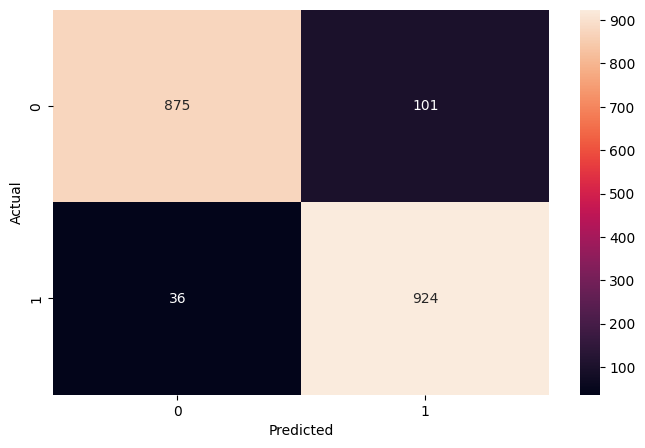

Accuracy: 0.9941890495867769
Precision: 0.9922978177150192
Recall: 0.9961340206185567
F1-Score: 0.9942122186495176
Confusion Matrix :
[[3834   30]
 [  15 3865]]

 Report : 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3864
           1       0.99      1.00      0.99      3880

    accuracy                           0.99      7744
   macro avg       0.99      0.99      0.99      7744
weighted avg       0.99      0.99      0.99      7744



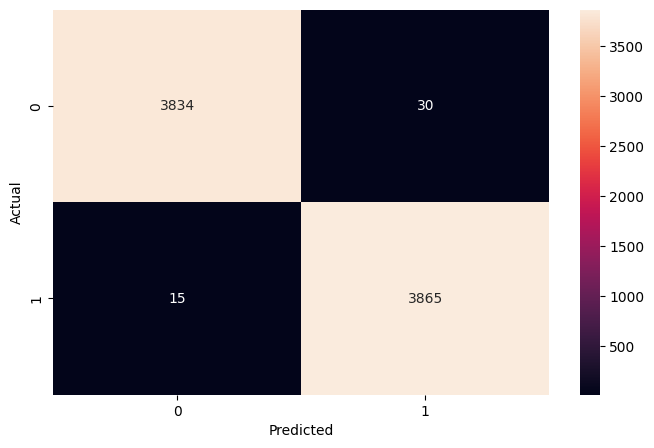

In [8]:
y_pred_train = svm_model.predict(X_train_tfidf)
y_pred_test = svm_model.predict(X_test_tfidf)

model_predict(svm_model, y_test, y_pred_test)
model_predict(svm_model, y_train, y_pred_train)

### Section 3.2: SVM with TF-IDF (Stratified Data)

In [9]:
X_train, X_test, y_train, y_test = split_stratified_data()
X_train_tfidf, X_test_tfidf, vectorizer = term_weighting_tfidf(X_train, X_test)

print('Train data count: ', len(X_train))
print('Train data positive count: ', len(y_train[y_train == 1]))
print('Train data negative count: ', len(y_train[y_train == 0]))
print('Test data count: ', len(X_test))
print('Test data positive count: ', len(y_test[y_test == 1]))
print('Test data negative count: ', len(y_test[y_test == 0]))
print()
print(df.shape)

svm_model = load_svm_model()
svm_model.fit(X_train_tfidf, y_train)

model_score = svm_model.score(X_test_tfidf, y_test)
print("Model score: ", model_score)

Train data count:  7744
Train data positive count:  3872
Train data negative count:  3872
Test data count:  1936
Test data positive count:  968
Test data negative count:  968

(9680, 11)
Parameters:  {'C': 3.8286206358121855, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.014035078041264516, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Model score:  0.9426652892561983


#### Section 3.2.1: Evaluation

Accuracy: 0.9426652892561983
Precision: 0.9221674876847291
Recall: 0.9669421487603306
F1-Score: 0.9440242057488654
Confusion Matrix :
[[889  79]
 [ 32 936]]

 Report : 
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       968
           1       0.92      0.97      0.94       968

    accuracy                           0.94      1936
   macro avg       0.94      0.94      0.94      1936
weighted avg       0.94      0.94      0.94      1936



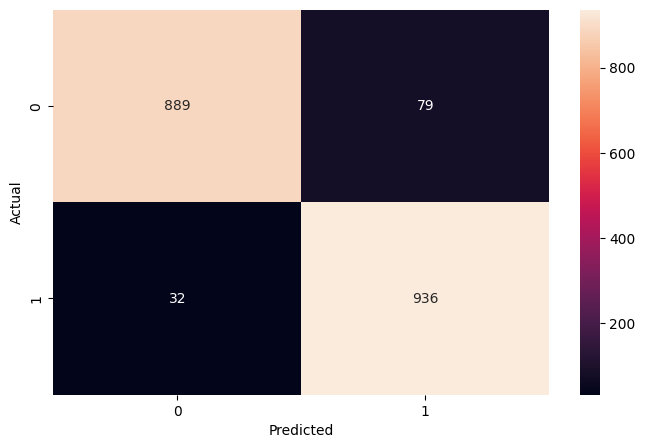

Accuracy: 0.9948347107438017
Precision: 0.992798353909465
Recall: 0.996900826446281
F1-Score: 0.9948453608247423
Confusion Matrix :
[[3844   28]
 [  12 3860]]

 Report : 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3872
           1       0.99      1.00      0.99      3872

    accuracy                           0.99      7744
   macro avg       0.99      0.99      0.99      7744
weighted avg       0.99      0.99      0.99      7744



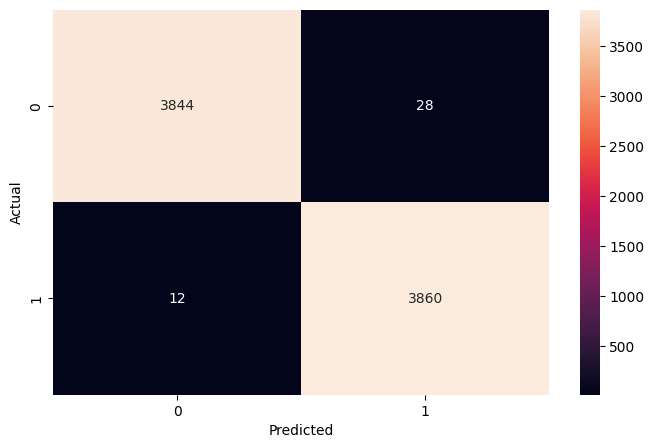

In [10]:
y_pred_train = svm_model.predict(X_train_tfidf)
y_pred_test = svm_model.predict(X_test_tfidf)

model_predict(svm_model, y_test, y_pred_test)
model_predict(svm_model, y_train, y_pred_train)

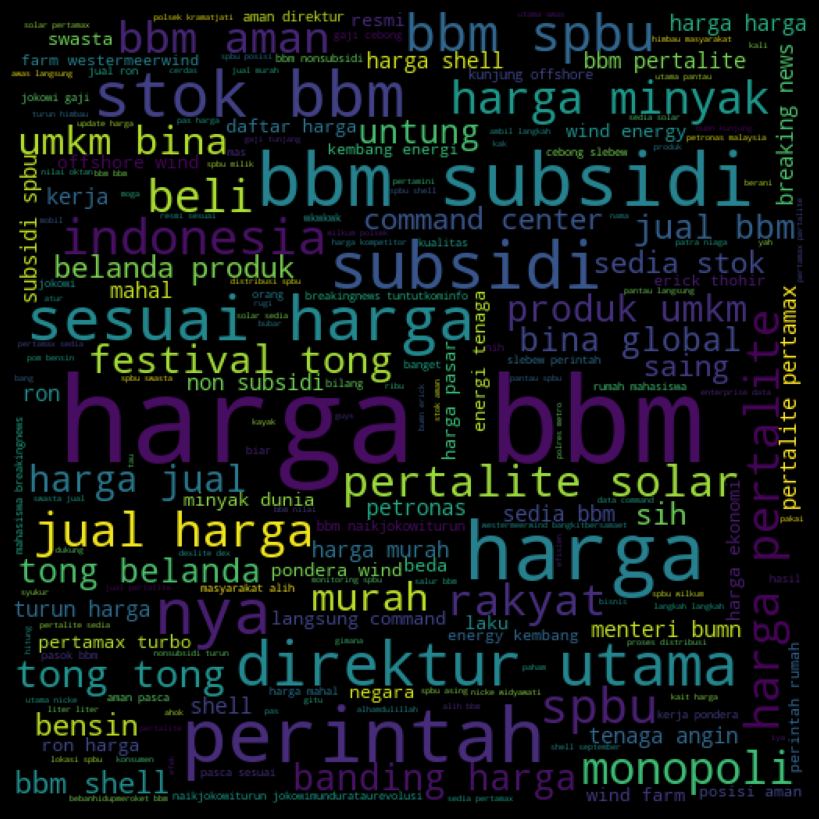

In [11]:
#word cloud for positive review words
pos_words = ' '.join(list(df[df['sentiment'] == 1]['review']))
pos_wordcloud = WordCloud(width=512,height=512).generate(pos_words)
plt.figure(figsize=(10,8),facecolor = 'k')
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

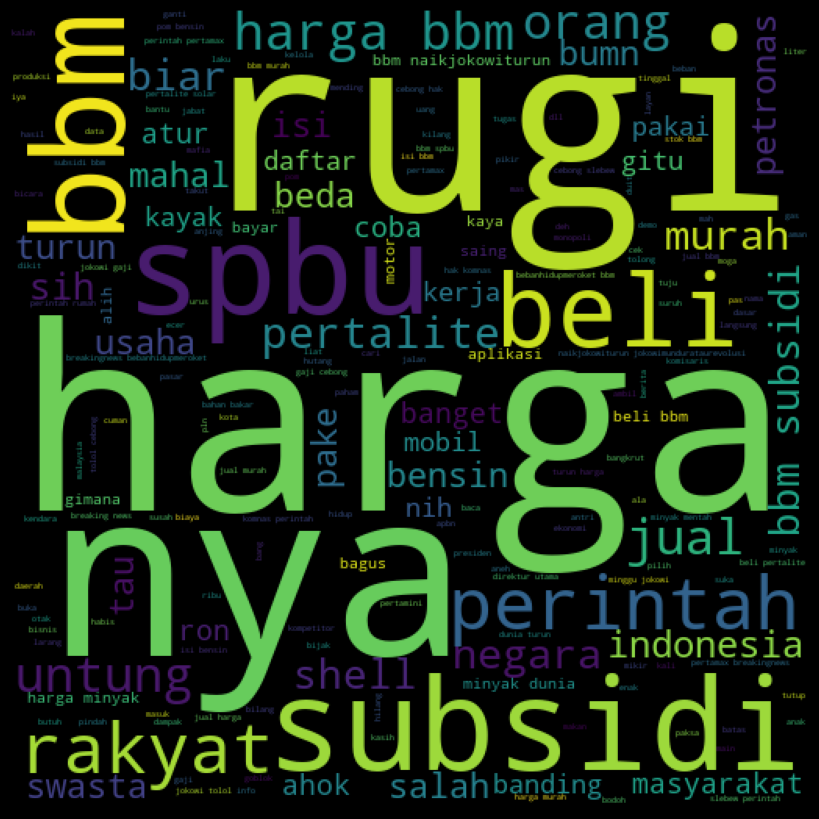

In [12]:
#word cloud for negative review words
neg_words = ' '.join(list(df[df['sentiment'] == 0]['review']))
neg_wordcloud = WordCloud(width=512,height=512).generate(neg_words)
plt.figure(figsize=(10,8),facecolor = 'k')
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Section 4: Test & Conclusion

In [13]:
%run "../shared.py"

In [14]:
# Results from prediction sentiment on data test

texts = df['review']
text_train, text_test = train_test_split(texts, test_size=0.2, random_state=687)

result_test = pd.DataFrame(data=zip(text_test, y_pred_test), columns=['review', 'polarity'])

polarity_decode = {0 : 'Negative', 1 : 'Positive'}
result_test['polarity'] = result_test['polarity'].map(polarity_decode)

pd.set_option('max_colwidth', 300)
result_test.sample(10)

,review,polarity
448,pom franchise put ketat awas,Negative
428,kasi teman teman guru honorer gaji tau kayak bayang gimana atur uang adakalanya puji perintah dpr kali sepakat puji,Positive
1234,harga bbm noh,Negative
1889,hancur komnas ham putri panggil kuat damai ribut keras seksual percaya jokowi gaji cebong slebew perintah rumah mahasiswa breakingnews tuntutkominfo jokowimundurataurevolusi,Positive
1546,bat tulis jalur bbm subsidi monmaap nihh walopun pake motor biar cepet yaa isi non subsidi suruh muter ngantri jalur bbm subsidi hih,Negative
1882,janji ngantri ngantri,Positive
784,rewel tinggal,Negative
835,dadak hilang mafia takut saing lawan bredel,Positive
1791,sesuai harga bbm resmi subsidi perintah bahan bakar minyak sasar terima penyaluranbltbbmtepat,Negative
1542,harga minyak dunia turun,Positive


In [15]:
sample_text = 'Kami Mendukung Keputusan PemeRintah untUk menAIkkan HARga BBM'
sample_text = preprocess_text(sample_text)

sample_text_tfidf = vectorizer.transform([sample_text])
polarity = svm_model.predict(sample_text_tfidf)

sentiment = polarity_decode[polarity[0]]

print(f"Sampel text: {sample_text}")
print(f"Sentiment: {sentiment}")

Normalization list: 1034
Indonesian stopwords: 758
English stopwords: 179
Custom stopwords: 8
Total stopwords: 945
Sampel text: dukung putus perintah naik harga bbm
Sentiment: Positive


In [16]:
sample_text = 'saya benci pemerintah'
sample_text = preprocess_text(sample_text)

sample_text_tfidf = vectorizer.transform([sample_text])
polarity = svm_model.predict(sample_text_tfidf)

sentiment = polarity_decode[polarity[0]]

print(f"Sampel text: {sample_text}")
print(f"Sentiment: {sentiment}")

Normalization list: 1034
Indonesian stopwords: 758
English stopwords: 179
Custom stopwords: 8
Total stopwords: 945
Sampel text: benci perintah
Sentiment: Negative


In [17]:
save_model(svm_model)
save_vectorizer(vectorizer)